In [517]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [518]:
# Frecuencia MCU = 16 MHz
def ticks_to_sec(ticks):
    return ticks / 16e6

def ticks_to_msec(ticks):
    return ticks / 16e6 * 1e3

def ticks_to_usec(ticks):
    return ticks / 16e6 * 1e6

In [519]:
tipo = 'O' # Orchestra ('O') o Minimal ('M')
topo = 'L' # Estrella ('E') o Lineal ('L')
motes_q = 10 # Cantidad de motes: [5, ... , 10]

In [520]:
tipo_path = 'orchestra\\' if tipo == 'O' else 'minimal\\'
topo_path = 'estrella\\' if topo == 'E' else 'lineal\\'
df = pd.read_excel('procesados\\' + tipo_path + topo_path + 'analisis_' + topo + '_' + str(motes_q) + '.xlsx', sheet_name='Hoja2')
df_final = pd.DataFrame()
df_avg = pd.DataFrame()

In [521]:
# df.columns

In [522]:
# Agregar intensidad y slotframe a df_final
df_final[['intensidad', 'slotframe']] = df[['intensidad', 'slotframe']]
# Agregar intensidad a df_avg
df_avg['intensidad'] = df['intensidad']
# Obtener intensidades y slotframes probados
intensidad = sorted(df['intensidad'].unique())
slotframe = sorted(df['slotframe'].unique())

### PDR vs Intensidad

In [523]:
# Agregar datos de PDR
motes_extra = 2 if topo == 'E' else 1 # Se agrega nodo adicional por nodo aislado si es estrella
for i in range(2, motes_q + motes_extra):
    df['pdr_' + str(i)] = df['pkt_rcv_' + str(i)] / df['pkt_sent_' + str(i)] * 100

In [524]:
# Descartar columnas con todos los elementos NaN
df.dropna(axis='columns', how='all', inplace=True)

In [525]:
pdr_cols = [col for col in df if col.startswith('pdr')]
df[pdr_cols]
df.sort_values(by=['intensidad', 'slotframe'], inplace=True)
df[['intensidad', 'slotframe'] + pdr_cols]

,intensidad,slotframe,pdr_2,pdr_3,pdr_4,pdr_5,pdr_6,pdr_7,pdr_8,pdr_9,pdr_10
7,3,7,100.0,100.0,100.0,99.823633,99.122807,98.738739,99.461400,98.526703,98.892989
1,3,17,100.0,100.0,100.0,100.000000,100.000000,100.000000,100.000000,NaN,NaN
4,3,27,100.0,100.0,100.0,100.000000,99.648506,100.000000,99.821747,99.818182,NaN
8,8,7,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,17,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,8,27,100.0,100.0,100.0,100.000000,NaN,NaN,NaN,NaN,NaN
6,19,7,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,19,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [526]:
# PDR de la red, dada una intensidad y un slotframe
for i in intensidad:
    for s in slotframe:
        df_final.loc[(df_final['intensidad'] == i) & (df_final['slotframe'] == s), 'pdr'] = \
            df[(df['intensidad'] == i) & (df['slotframe'] == s)][pdr_cols].mean(axis='columns')

### Delay vs Intensidad

In [527]:
# Reemplazar -1 por NaN
df.replace(to_replace=-1, value=np.nan, inplace=True)
# Descartar columnas con todos los elementos NaN
df.dropna(axis='columns', how='all', inplace=True)

In [528]:
delay_cols = [col for col in df if 'avg' in col]
df[['intensidad', 'slotframe'] + delay_cols]

,intensidad,slotframe,delays_2_avg,delays_3_avg,delays_4_avg,delays_5_avg,delays_6_avg,delays_7_avg,delays_8_avg,delays_9_avg,delays_10_avg
7,3,7,6992.0,1126.0,215.0,4909.0,398.0,3212.0,6628.0,3105.0,6614.0
1,3,17,5661.0,2004.0,3282.0,3312.0,5588.0,2767.0,4004.0,NaN,NaN
4,3,27,4509.0,1008.0,2826.0,3122.0,4545.0,385.0,4627.0,5008.0,NaN
8,8,7,541.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,17,1939.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,8,27,7299.0,10.0,1877.0,2634.0,NaN,NaN,NaN,NaN,NaN
6,19,7,5657.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,19,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [529]:
# delay de la red, dada una intensidad y un slotframe
for i in intensidad:
    for s in slotframe:
        df_final.loc[(df_final['intensidad'] == i) & (df_final['slotframe'] == s), 'delay'] = \
            df[(df['intensidad'] == i) & (df['slotframe'] == s)][delay_cols].mean(axis='columns').apply(ticks_to_usec)

### Duty Cycle vs Intensidad

#### RADIO ON

In [530]:
# Agregar datos de Radio ON
motes_extra = 2 if topo == 'E' else 1 # Se agrega nodo adicional por nodo aislado si es estrella
for i in range(1, motes_q + motes_extra):
    if df['duty_cycle_' + str(i) + '_TRANSMIT'].max() > 0: # Contar solo los nodos que se enganchan
        df['radio_on_' + str(i)] = df['duty_cycle_' + str(i) + '_Radio LISTEN'] + df['duty_cycle_' + str(i) + '_TRANSMIT']

In [531]:
# Quedarse con columnas relativas a radio_ON, correspondientes a nodos sender
radio_on_cols = [col for col in df if col.startswith('radio_on') and col.split("_")[-1] != '1']
df[['intensidad', 'slotframe'] + radio_on_cols]

,intensidad,slotframe,radio_on_2,radio_on_3,radio_on_4,radio_on_5,radio_on_6,radio_on_7,radio_on_8,radio_on_9,radio_on_10
7,3,7,2819641,2752933,3000934,3017882,4391785,4386030,4386517,4682205,5163772
1,3,17,2724198,3146545,4020983,4032150,4395707,4774626,5152834,5706402,6764455
4,3,27,2755355,2707679,3603274,4160652,4171721,4252428,4523853,4760076,6876190
8,8,7,2455633,6884100,6761140,7485365,7513616,7812789,8108560,8855796,11344153
2,8,17,2467356,5481540,6365393,6412294,6410853,6501320,11904069,12210320,12323258
5,8,27,2508659,2886252,2987446,3602971,5973271,6054995,6211361,9479321,10138287
6,19,7,3195579,4889332,4947962,4961533,5412626,6710662,7445847,7923177,8426107
0,19,17,6318924,6830791,7744600,8003955,8194063,8443833,8726633,8812937,10176127
3,19,27,6315819,6380132,6642113,7425100,8903291,11046184,12906560,13028326,13455296


In [532]:
# Consumo "Radio ON" de la red (solo senders), dada una intensidad y un slotframe
for i in intensidad:
    for s in slotframe:
        df_final.loc[(df_final['intensidad'] == i) & (df_final['slotframe'] == s), 'radio_on'] = \
            df[(df['intensidad'] == i) & (df['slotframe'] == s)][radio_on_cols].mean(axis='columns').apply(ticks_to_msec)

#### LISTEN

In [533]:
# Quedarse con columnas relativas a LISTEN, correspondientes a nodos sender...
listen_si_cols = list() # ...considerando nodos que SÍ se engancharon
listen_no_cols = list() # ...considerando nodos que NO se engancharon
for col in df:
    if 'LISTEN' in col: # columnas de LISTEN
        mote_id = col.split("_")[-2] # formato: duty_cycle_3_Radio LISTEN
        if mote_id != '1': # solo nodos sender
            aux_col = 'duty_cycle_' + mote_id + '_TRANSMIT'
            if aux_col in df.columns and df[aux_col].max() > 0: # nodos que se engancharon
                    listen_si_cols.append(col)
            else:
                    listen_no_cols.append(col)

In [534]:
print("Nodos sender que SÍ se engancharon:")
df[['intensidad', 'slotframe'] + listen_si_cols]

Nodos sender que SÍ se engancharon:


,intensidad,slotframe,duty_cycle_2_Radio LISTEN,duty_cycle_3_Radio LISTEN,duty_cycle_4_Radio LISTEN,duty_cycle_5_Radio LISTEN,duty_cycle_6_Radio LISTEN,duty_cycle_7_Radio LISTEN,duty_cycle_8_Radio LISTEN,duty_cycle_9_Radio LISTEN,duty_cycle_10_Radio LISTEN
7,3,7,2404034,2323539,2593659,2660525,4098784,4163080,4225311,4583132,5121808
1,3,17,2399737,2828940,3742636,3811249,4235751,4674698,5109403,5682953,6744147
4,3,27,2380729,2333099,3254576,3874305,3944486,4091553,4422218,4716849,6852979
8,8,7,2437212,6860874,6740596,7465241,7493460,7792769,8088892,8836084,11325405
2,8,17,2448858,5460409,6344801,6391686,6390393,6480684,11885549,12192112,12305074
5,8,27,2433230,2823746,2944404,3582345,5952314,6034183,6190701,9459877,10119275
6,19,7,3183718,4867678,4926750,4940469,5391506,6690326,7425599,7903369,8406243
0,19,17,6298207,6810587,7724772,7983935,8174123,8424173,8707229,8793413,10157139
3,19,27,6295086,6359780,6621925,7405084,8883999,11027528,12888708,13010434,13437640


In [535]:
# consumo "Listen" de la red (senders que SÍ se engancharon), dada una intensidad y un slotframe
for i in intensidad:
    for s in slotframe:
        df_final.loc[(df_final['intensidad'] == i) & (df_final['slotframe'] == s), 'listen_si'] = \
            df[(df['intensidad'] == i) & (df['slotframe'] == s)][listen_si_cols].mean(axis='columns').apply(ticks_to_msec)

In [536]:
# consumo "Listen" de la red (senders que SÍ se engancharon), dada una intensidad
df_aux = df.groupby('intensidad')[listen_si_cols].mean().mean(axis='columns').apply(ticks_to_msec).reset_index()
df_aux.columns = ['intensidad', 'listen_si_avg']
df_avg = pd.merge(df_avg, df_aux, on='intensidad')

In [537]:
print("Nodos sender que NO se engancharon:")
df[['intensidad', 'slotframe'] + listen_no_cols]

Nodos sender que NO se engancharon:


,intensidad,slotframe
7,3,7
1,3,17
4,3,27
8,8,7
2,8,17
5,8,27
6,19,7
0,19,17
3,19,27


In [538]:
# consumo "Listen" de la red (senders que NO se engancharon), dada una intensidad y un slotframe
for i in intensidad:
    for s in slotframe:
        df_final.loc[(df_final['intensidad'] == i) & (df_final['slotframe'] == s), 'listen_no'] = \
            df[(df['intensidad'] == i) & (df['slotframe'] == s)][listen_no_cols].mean(axis='columns').apply(ticks_to_msec)

In [539]:
# consumo "Listen" de la red (senders que NO se engancharon), dada una intensidad
if listen_no_cols: # Si la lista no está vacía
    df_aux = df.groupby('intensidad')[listen_no_cols].mean().mean(axis='columns').apply(ticks_to_msec).reset_index()
    df_aux.columns = ['intensidad', 'listen_no_avg']
    df_avg = pd.merge(df_avg, df_aux, on='intensidad')

#### TRANSMIT

In [540]:
# Reemplazar 0 por NaN
df.replace(to_replace=0, value=np.nan, inplace=True)
# Descartar columnas con todos los elementos NaN
df.dropna(axis='columns', how='all', inplace=True)

In [541]:
# Quedarse con columnas relativas a radio_ON, correspondientes a nodos sender
tx_cols = [col for col in df if 'TRANSMIT' in col and col.split("_")[-2] != '1']
df[['intensidad', 'slotframe'] + tx_cols]

,intensidad,slotframe,duty_cycle_2_TRANSMIT,duty_cycle_3_TRANSMIT,duty_cycle_4_TRANSMIT,duty_cycle_5_TRANSMIT,duty_cycle_6_TRANSMIT,duty_cycle_7_TRANSMIT,duty_cycle_8_TRANSMIT,duty_cycle_9_TRANSMIT,duty_cycle_10_TRANSMIT
7,3,7,415607,429394,407275,357357,293001,222950,161206,99073,41964
1,3,17,324461,317605,278347,220901,159956,99928,43431,23449,20308
4,3,27,374626,374580,348698,286347,227235,160875,101635,43227,23211
8,8,7,18421,23226,20544,20124,20156,20020,19668,19712,18748
2,8,17,18498,21131,20592,20608,20460,20636,18520,18208,18184
5,8,27,75429,62506,43042,20626,20957,20812,20660,19444,19012
6,19,7,11861,21654,21212,21064,21120,20336,20248,19808,19864
0,19,17,20717,20204,19828,20020,19940,19660,19404,19524,18988
3,19,27,20733,20352,20188,20016,19292,18656,17852,17892,17656


In [542]:
# consumo "TRANSMIT" de la red (solo senders), dada una intensidad y un slotframe
for i in intensidad:
    for s in slotframe:
        df_final.loc[(df_final['intensidad'] == i) & (df_final['slotframe'] == s), 'tx'] = \
            df[(df['intensidad'] == i) & (df['slotframe'] == s)][tx_cols].mean(axis='columns').apply(ticks_to_msec)

#### CPU

In [543]:
# Quedarse con columnas relativas a CPU, correspondientes a nodos sender...
cpu_si_cols = list() # ...considerando nodos que SÍ se engancharon
cpu_no_cols = list() # ...considerando nodos que NO se engancharon
for col in df:
    if 'CPU' in col: # columnas de CPU
        mote_id = col.split("_")[-2] # formato: duty_cycle_3_CPU
        if mote_id != '1': # solo nodos sender
            aux_col = 'duty_cycle_' + mote_id + '_TRANSMIT'
            if aux_col in df.columns and df[aux_col].max() > 0: # nodos que se engancharon
                    cpu_si_cols.append(col)
            else:
                    cpu_no_cols.append(col)

In [544]:
print("Nodos sender que SÍ se engancharon:")
df[['intensidad', 'slotframe'] + cpu_si_cols]

Nodos sender que SÍ se engancharon:


,intensidad,slotframe,duty_cycle_2_CPU,duty_cycle_3_CPU,duty_cycle_4_CPU,duty_cycle_5_CPU,duty_cycle_6_CPU,duty_cycle_7_CPU,duty_cycle_8_CPU,duty_cycle_9_CPU,duty_cycle_10_CPU
7,3,7,5434473,5025345,4611092,4026024,3660063,3121807,2689018,2191335,1759612
1,3,17,4447653,4011681,3569916,3143657,2690254,2210118,1778017,1613497,1676349
4,3,27,4944866,4430972,4043865,3620796,3203089,2657523,2272864,1798707,1710200
8,8,7,921846,1231301,1245341,1281811,1284093,1297883,1312513,1359021,1471453
2,8,17,886938,1133501,1254076,1249083,1226168,1214171,1551778,1523455,1502710
5,8,27,1429778,1324717,1134941,963331,1154166,1226900,1219968,1376216,1411264
6,19,7,675500,981366,988638,974406,1002101,1064725,1109412,1156612,1136978
0,19,17,1009280,1062206,1161983,1136093,1150807,1174935,1167400,1172910,1228938
3,19,27,1053613,1041007,1055955,1094742,1179158,1293504,1400573,1441627,1442531


In [545]:
# consumo "CPU" de la red (senders que SÍ se engancharon), dada una intensidad y un slotframe
for i in intensidad:
    for s in slotframe:
        df_final.loc[(df_final['intensidad'] == i) & (df_final['slotframe'] == s), 'cpu_si'] = \
            df[(df['intensidad'] == i) & (df['slotframe'] == s)][cpu_si_cols].mean(axis='columns').apply(ticks_to_msec)

In [546]:
# consumo "CPU" de la red (senders que SÍ se engancharon), dada una intensidad
df_aux = df.groupby('intensidad')[cpu_si_cols].mean().mean(axis='columns').apply(ticks_to_msec).reset_index()
df_aux.columns = ['intensidad', 'cpu_si_avg']
df_avg = pd.merge(df_avg, df_aux, on='intensidad')

In [547]:
print("Nodos sender que NO se engancharon:")
df[['intensidad', 'slotframe'] + cpu_no_cols]

Nodos sender que NO se engancharon:


,intensidad,slotframe
7,3,7
1,3,17
4,3,27
8,8,7
2,8,17
5,8,27
6,19,7
0,19,17
3,19,27


In [548]:
# consumo "CPU" de la red (senders que NO se engancharon), dada una intensidad y un slotframe
for i in intensidad:
    for s in slotframe:
        df_final.loc[(df_final['intensidad'] == i) & (df_final['slotframe'] == s), 'cpu_no'] = \
            df[(df['intensidad'] == i) & (df['slotframe'] == s)][cpu_no_cols].mean(axis='columns').apply(ticks_to_msec)

In [549]:
# consumo "CPU" de la red (senders que NO se engancharon), dada una intensidad
if cpu_no_cols: # Si la lista no está vacía
    df_aux = df.groupby('intensidad')[cpu_no_cols].mean().mean(axis='columns').apply(ticks_to_msec).reset_index()
    df_aux.columns = ['intensidad', 'cpu_no_avg']
    df_avg = pd.merge(df_avg, df_aux, on='intensidad')

### DataFrames final y avg

In [550]:
df_final.sort_values(by=['intensidad', 'slotframe'], inplace=True)
df_final

,intensidad,slotframe,pdr,delay,radio_on,listen_si,listen_no,tx,cpu_si,cpu_no
7,3,7,99.396252,230.548611,240.289576,223.429667,NaN,16.859910,225.824785,NaN
1,3,17,100.000000,237.660714,282.763194,272.427181,NaN,10.336014,174.591264,NaN
4,3,27,99.911054,203.359375,262.577972,249.102736,NaN,13.475236,199.186681,NaN
8,8,7,100.000000,33.812500,466.813556,465.559257,NaN,1.254299,79.203208,NaN
2,8,17,100.000000,121.187500,486.641687,485.413653,NaN,1.228035,80.151944,NaN
5,8,27,100.000000,184.687500,346.128910,344.028299,NaN,2.100611,78.064451,NaN
6,19,7,100.000000,353.562500,374.394618,373.164292,NaN,1.230326,63.123181,NaN
0,19,17,NaN,NaN,508.693493,507.455403,NaN,1.238090,71.281611,NaN
3,19,27,NaN,NaN,597.936257,596.737389,NaN,1.198868,76.407708,NaN


In [551]:
df_avg.sort_values(by='intensidad', inplace=True)
df_avg

,intensidad,listen_si_avg,cpu_si_avg
3,3,248.319861,199.867576
4,3,248.319861,199.867576
5,3,248.319861,199.867576
6,8,431.667069,79.139868
7,8,431.667069,79.139868
8,8,431.667069,79.139868
0,19,492.452361,70.270833
1,19,492.452361,70.270833
2,19,492.452361,70.270833


### Gráficas

#### PDR vs Intensidad

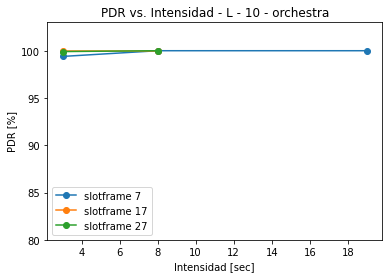

In [552]:
legend = list()
for s in slotframe:
    plt.plot(df_final[df_final['slotframe'] == s]['intensidad'], df_final[df_final['slotframe'] == s]['pdr'], linestyle='-', marker='o')
    legend.append("slotframe " + str(s))
plt.ylim(80, 103)
plt.title("PDR vs. Intensidad - " + topo + " - " + str(motes_q) + " - " +  tipo_path[:-1])
plt.xlabel('Intensidad [sec]')
plt.ylabel('PDR [%]')
plt.legend(legend)
plt.show()

#### Delay vs Intensidad

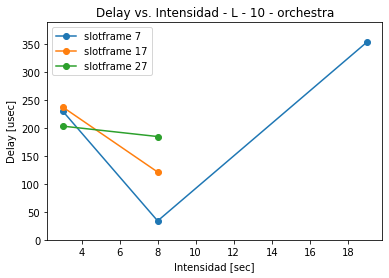

In [553]:
legend = list()
for s in slotframe:
    plt.plot(df_final[df_final['slotframe'] == s]['intensidad'], df_final[df_final['slotframe'] == s]['delay'], linestyle='-', marker='o')
    legend.append("slotframe " + str(s))
plt.ylim(0, (df_final['delay'].max() + df_final['delay'].max() * 0.1)) # Ajustar la escala a 10% más del valor máximo
plt.title("Delay vs. Intensidad - " + topo + " - " + str(motes_q) + " - " +  tipo_path[:-1])
plt.xlabel('Intensidad [sec]')
plt.ylabel('Delay [usec]')
plt.legend(legend)
plt.show()

#### Duty Cycle vs Intensidad

##### RADIO ON

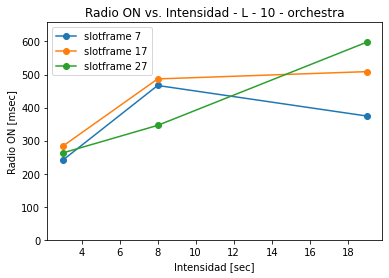

In [554]:
legend = list()
for s in slotframe:
    plt.plot(df_final[df_final['slotframe'] == s]['intensidad'], df_final[df_final['slotframe'] == s]['radio_on'], linestyle='-', marker='o')
    legend.append("slotframe " + str(s))
plt.ylim(0, (df_final['radio_on'].max() + df_final['radio_on'].max() * 0.1)) # Ajustar la escala a 10% más del valor máximo
plt.title("Radio ON vs. Intensidad - " + topo + " - " + str(motes_q) + " - " +  tipo_path[:-1])
plt.xlabel('Intensidad [sec]')
plt.ylabel('Radio ON [msec]')
plt.legend(legend)
plt.show()

##### LISTEN

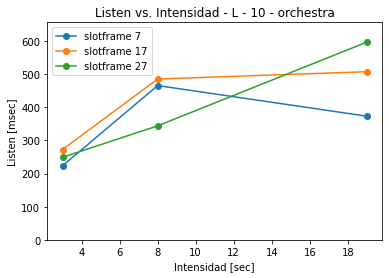

In [555]:
legend = list()
for s in slotframe:
    plt.plot(df_final[df_final['slotframe'] == s]['intensidad'], df_final[df_final['slotframe'] == s]['listen_si'], linestyle='-', marker='o')
    legend.append("slotframe " + str(s))
plt.ylim(0, (df_final['listen_si'].max() + df_final['listen_si'].max() * 0.1)) # Ajustar la escala a 10% más del valor máximo
plt.title("Listen vs. Intensidad - " + topo + " - " + str(motes_q) + " - " +  tipo_path[:-1])
plt.xlabel('Intensidad [sec]')
plt.ylabel('Listen [msec]')
plt.legend(legend)
plt.show()

In [556]:
if listen_no_cols: # Si la lista no está vacía
    plt.plot(df_avg['intensidad'], df_avg['listen_si_avg'], linestyle='-', marker='o')
    plt.plot(df_avg['intensidad'], df_avg['listen_no_avg'], linestyle='-', marker='o')
    plt.title("Listen vs. Intensidad - " + topo + " - " + str(motes_q) + " - " +  tipo_path[:-1])
    plt.xlabel('Intensidad [sec]')
    plt.ylabel('Listen [msec]')
    plt.legend(['sí enganchados', 'no enganchados'])
    plt.show()

    print("Nodos no enganchados: ", [i.split("_")[-2] for i in listen_no_cols])

##### TRANSMIT

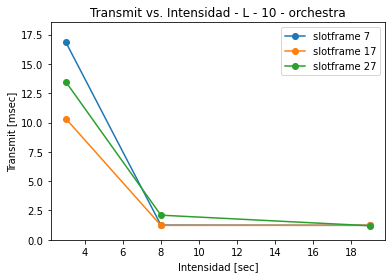

In [557]:
legend = list()
for s in slotframe:
    plt.plot(df_final[df_final['slotframe'] == s]['intensidad'], df_final[df_final['slotframe'] == s]['tx'], linestyle='-', marker='o')
    legend.append("slotframe " + str(s))
plt.ylim(0, (df_final['tx'].max() + df_final['tx'].max() * 0.1)) # Ajustar la escala a 10% más del valor máximo
plt.title("Transmit vs. Intensidad - " + topo + " - " + str(motes_q) + " - " +  tipo_path[:-1])
plt.xlabel('Intensidad [sec]')
plt.ylabel('Transmit [msec]')
plt.legend(legend)
plt.show()

##### CPU

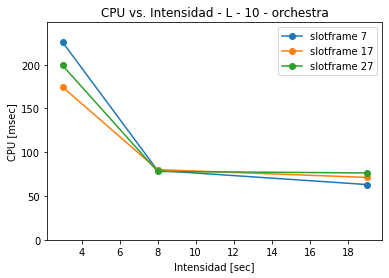

In [558]:
legend = list()
for s in slotframe:
    plt.plot(df_final[df_final['slotframe'] == s]['intensidad'], df_final[df_final['slotframe'] == s]['cpu_si'], linestyle='-', marker='o')
    legend.append("slotframe " + str(s))
plt.ylim(0, (df_final['cpu_si'].max() + df_final['cpu_si'].max() * 0.1)) # Ajustar la escala a 10% más del valor máximo
plt.title("CPU vs. Intensidad - " + topo + " - " + str(motes_q) + " - " +  tipo_path[:-1])
plt.xlabel('Intensidad [sec]')
plt.ylabel('CPU [msec]')
plt.legend(legend)
plt.show()

In [559]:
if cpu_no_cols: # Si la lista no está vacía
    plt.plot(df_avg['intensidad'], df_avg['cpu_si_avg'], linestyle='-', marker='o')
    plt.plot(df_avg['intensidad'], df_avg['cpu_no_avg'], linestyle='-', marker='o')
    plt.title("CPU vs. Intensidad - " + topo + " - " + str(motes_q) + " - " +  tipo_path[:-1])
    plt.xlabel('Intensidad [sec]')
    plt.ylabel('Listen [msec]')
    plt.legend(['sí enganchados', 'no enganchados'])
    plt.show()

    print("Nodos no enganchados: ", [i.split("_")[-2] for i in listen_no_cols])